# Tutorial: Nonadiabatic Dynamics with QTAG Trajectories

The purpose of this tutorial is to guide the user through running a QTAG calculation of wavepacket dynamics, including initializing input parameter dictionaries and visualizing the resultant data with Python's MatPlotLib.

## Table of Contents

1. [Defining the Model Hamiltonian](#Defining-the-Model-Hamiltonian)
2. [Running QTAG Dynamics](#Running-QTAG-Dynamics)
3. [Data Visualization](#Data-Visualization)

## Learning Objectives

+ To be able to create a custom potential for the QTAG algorithm
+ To be able to run a QTAG dynamics calculation
+ To be able to visualize QTAG-guided trajectories and wavefunctions

## Functions

* `libra.py`
    * `dynamics`
        * `qtag`

Import the necessary Python and Libra modules...

In [1]:
#Various Python modules for basic needs.
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

#Core Libra routines for model potentials, data types, etc.
from liblibra_core import *
import libra_py.models.Holstein as Holstein
import util.libutil as comn
import libra_py.data_savers as data_savers
import libra_py.data_outs as data_outs
from libra_py import dynamics_plotting

#QTAG modules implemented in Libra.
import libra_py.dynamics.qtag.compute as compute
import libra_py.dynamics.qtag.qtag_calc as qtag_calc
import libra_py.dynamics.qtag.initialize as initialize
import libra_py.dynamics.qtag.qtag_mom as qtag_mom
import libra_py.dynamics.qtag.qtag_prop as qtag_prop
import libra_py.dynamics.qtag.plot as plot
import libra_py.dynamics.qtag.save as save

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

## 1. Defining the Model Hamiltonian

[Back to TOC](#Table-of-Contents) <a name="Defining-the-Model-Hamiltonian"></a>

The model Hamiltonian used in this tutorial is a two-state boson model consisting of two (harmonic) diabatic surfaces with a Gaussian coupling potential centered at their intersection:

$$ H_{n} = E_{n} + \frac{k}{2}(x-x_{n})^2 $$
$$ H_{nm} = V_{nm}e^{-\alpha_{nm}(x-x_{nm})^2} $$

When defining this model, one convenient option is to use the built-in function named `Holstein5` from the `libra_py/models` directory, which requires only that the Hamiltonian parameters be defined in a Python dictionary. Another option is to create a custom variant, as shown below in the `user_defined_model` function. For demonstration purposes, the initial content of this function is identical to that of `Holstein5`. In either case, the function requires three arguments:

- **q** -- the position at which the potential surfaces are to be evaluated. In QTAG, this coincides with a trajectory location.
- **model_params** -- the dictionary containing the Holstein model parameters.
- **full_id** -- an internal list of integers (not defined by the user).

The first thing we need to do is create the potential(s) for our simulations: this should be in the form of analytic functions defining at least one surface, and any coupling between surfaces. For this example, we will use the Holstein model function defined in Libra's model systems, although the general ``compute_model`` function will switch between functions identified by the ``model`` parameter in the ``model_params`` dictionary (which will be defined later).

Notice that the inputs to ``compute_model`` are ``q`` (the positions of the trajectories), ``model_params`` (a dictionary containing all model-specific parameters), and ``full_id`` (an internal identifier for Libra).

In [2]:
class tmp:
    pass

In [3]:
def user_defined_model(q, model_params, full_id):
    """
    n-state model

    H_nn = E_n + 0.5*k*(x-x_n)^2
    H_n,m = V_n,m * exp(- alp_n,m * (x-x_nm)^2 )

    Args:
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["E_n"]** ( list of doubles ):  [ default: [0.0, 0.001, 0.001, 0.001], units: Ha]
            * **params["x_n"]** ( list of doubles ):  [ default: [0.0, 1.0, 1.0, 1.0], units: Bohr]
            * **params["k_n"]** ( list of doubles ):  [ default: [0.001, 0.001, 0.001, 0.001], units: Ha/Bohr^2]
            * **params["V"]**   ( list of lists of double ):  [ default:  [[0.001]*4]*4, units: Ha]
            * **params["alpha"]** ( list of lists of double ):  [ default:  [[0.0]*4]*4, units: 1/Bohr^2]
            * **params["x_nm"]**  ( list of lists of double ):  [ default:  [[0.0]*4]*4, units: Bohr]

    Returns:
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(4,4) ): diabatic Hamiltonian
            * obj.ovlp_dia ( CMATRIX(4,4) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(4,4) objects ):
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.d2ham_dia ( list of 1 CMATRIX(4,4) objects ):
                second derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(4,4) objects ): derivative coupling in the diabatic basis [ zero ]

    """

    critical_params = ["E_n", "x_n", "k_n" ]
    default_params = { "V": [ [0.001, 0.001, 0.001, 0.001], [0.001, 0.001, 0.001, 0.001],
                              [0.001, 0.001, 0.001, 0.001], [0.001, 0.001, 0.001, 0.001] ],
                       "alpha": [ [0.00, 0.00, 0.00, 0.00], [0.00, 0.00, 0.00, 0.00],
                                  [0.00, 0.00, 0.00, 0.00], [0.00, 0.00, 0.00, 0.00] ],
                       "x_nm": [ [0.00, 0.00, 0.00, 0.00], [0.00, 0.00, 0.00, 0.00],
                                 [0.00, 0.00, 0.00, 0.00], [0.00, 0.00, 0.00, 0.00] ],
                     }
    comn.check_input(params, default_params, critical_params)

    E_n = params["E_n"]
    x_n = params["x_n"]
    k_n = params["k_n"]
    V = params["V"]
    alpha = params["alpha"]
    x_nm = params["x_nm"]

    n = len(E_n)

    Hdia = CMATRIX(n,n)
    Sdia = CMATRIX(n,n)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(n,n) )
    d2ham_dia = CMATRIXList();  d2ham_dia.append( CMATRIX(n,n) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(n,n) )

    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)

    Sdia.identity()

    for i in range(n):
        Hdia.set(i,i,  (E_n[i] + 0.5*k_n[i]*(x - x_n[i])**2) * (1.0+0.0j) )

    for i in range(n):
        for j in range(n):
            if i!=j:
                Hdia.set(i,j,  V[i][j] * math.exp(-alpha[i][j] * (x-x_nm[i][j])**2 ) * (1.0+0.0j) )
               
    for k in [0]:
        #  d Hdia / dR_0
        for i in range(n):
            d1ham_dia[k].set(i,i, (k_n[i] * (x - x_n[i]))*(1.0+0.0j) )

    for k in [0]:
        for i in range(n):
            for j in range(n):
                if i!=j:
                    d1ham_dia[k].set(i,j,  -2.0*alpha[i][j] * (x-x_nm[i][j]) * V[i][j] * math.exp(-alpha[i][j] * (x-x_nm[i][j])**2 ) * (1.0+0.0j) )
                    
    for k in [0]:
        #  d2 Hdia / dR_0 2
        for i in range(n):
            d2ham_dia[k].set(i,i, k_n[i]*(1.0+0.0j) )
      
    for k in [0]:
        for i in range(n):
            for j in range(n):
                if i!=j:
                    d2ham_dia[k].set(i,j, -2.0*alpha[i][j] * V[i][j] * math.exp(-alpha[i][j] * (x-x_nm[i][j])**2 )*(1.0-2.0*alpha[i][j]*(x-x_nm[i][j])**2)*(1.0+0.0j) )

    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.d2ham_dia = d2ham_dia
    obj.dc1_dia = dc1_dia

    return obj

Notice that the output of our potential function is a Python object called `obj` containing the requested Hamiltonian elements (`ham_dia`), along with their first (`d1ham_dia`) and second (`d2ham_dia`) derivatives. In the event that second derivatives aren't needed, there is no need to define this property.

For workflow flexibility, we quickly define a generic wrapper function called `compute_model`, which can be called in place of any specific model functions by including them as options in an if/else-if decision tree:

- `model` = 0: Use the built-in `Holstein5` function.
- `model` = 1: Use the custom `user_defined_model` function.

In [4]:
def compute_model(q, model_params, full_id):

    model = model_params["model"]
    res = None
    
    if model==0:
        res = Holstein.Holstein5(q, model_params, full_id)
    elif model==1:
        res = user_defined_model(q, model_params, full_id)
    else:
        print("Unrecognized model! Check for correct model import statement.")

    return res

Finally, we can define the Holstein parameters for our simulation:

In [5]:
#Potential parameters for Holstein5
model_params = {
    "model":0,
    "deriv_lvl":2,
    "E_n":[0.0,15.8114],
    "x_n":[0.0,1.0],
    "k_n":[10.0,10.0],
    "V":[[0.0,1.0],[1.0,0.0]],
    "alpha":[[0.0,1.5811],[1.5811,0.0]],
    "x_nm":[[0.0,2.0],[2.0,0.0]]
}

Before continuing to dynamics, it can be useful to plot the potential surfaces we've created. This is done using Libra's internal `dynamics_plotting` module, which requires us to define the `plot_params` dictionary:

In [6]:
help(dynamics_plotting.plot_surfaces)

Help on function plot_surfaces in module libra_py.dynamics_plotting:

plot_surfaces(_compute_model, _param_sets, states_of_interest, xmin, xmax, dx, plot_params, _ndof=1, _active_dof=0, _all_coordinates=[0.0])
    Args:
        _compute_model ( PyObject ): the function that returns the class with Hamiltonian properties
        _param_sets ( list of lists of dictionaries ): parameters of the model Hamiltonian, many sets are possible (hense the list)
    
            For each set, the following keywords are required:
            * **nstates** ( int ): the dimensionality of the Hamiltonian
    
        states_of_interest ( list of ints ): indices of the states we want to plot 
        xmin ( double ): minimal value of the x axis used in the actual PES calculations  [a.u.]
        xmax ( double ): maximal value of the x axis used in the actual PES calculations  [a.u.]
        dx ( double ): step size of PES scan [a.u.]
        plot_params ( dictionary ): the parameters of plotting
        

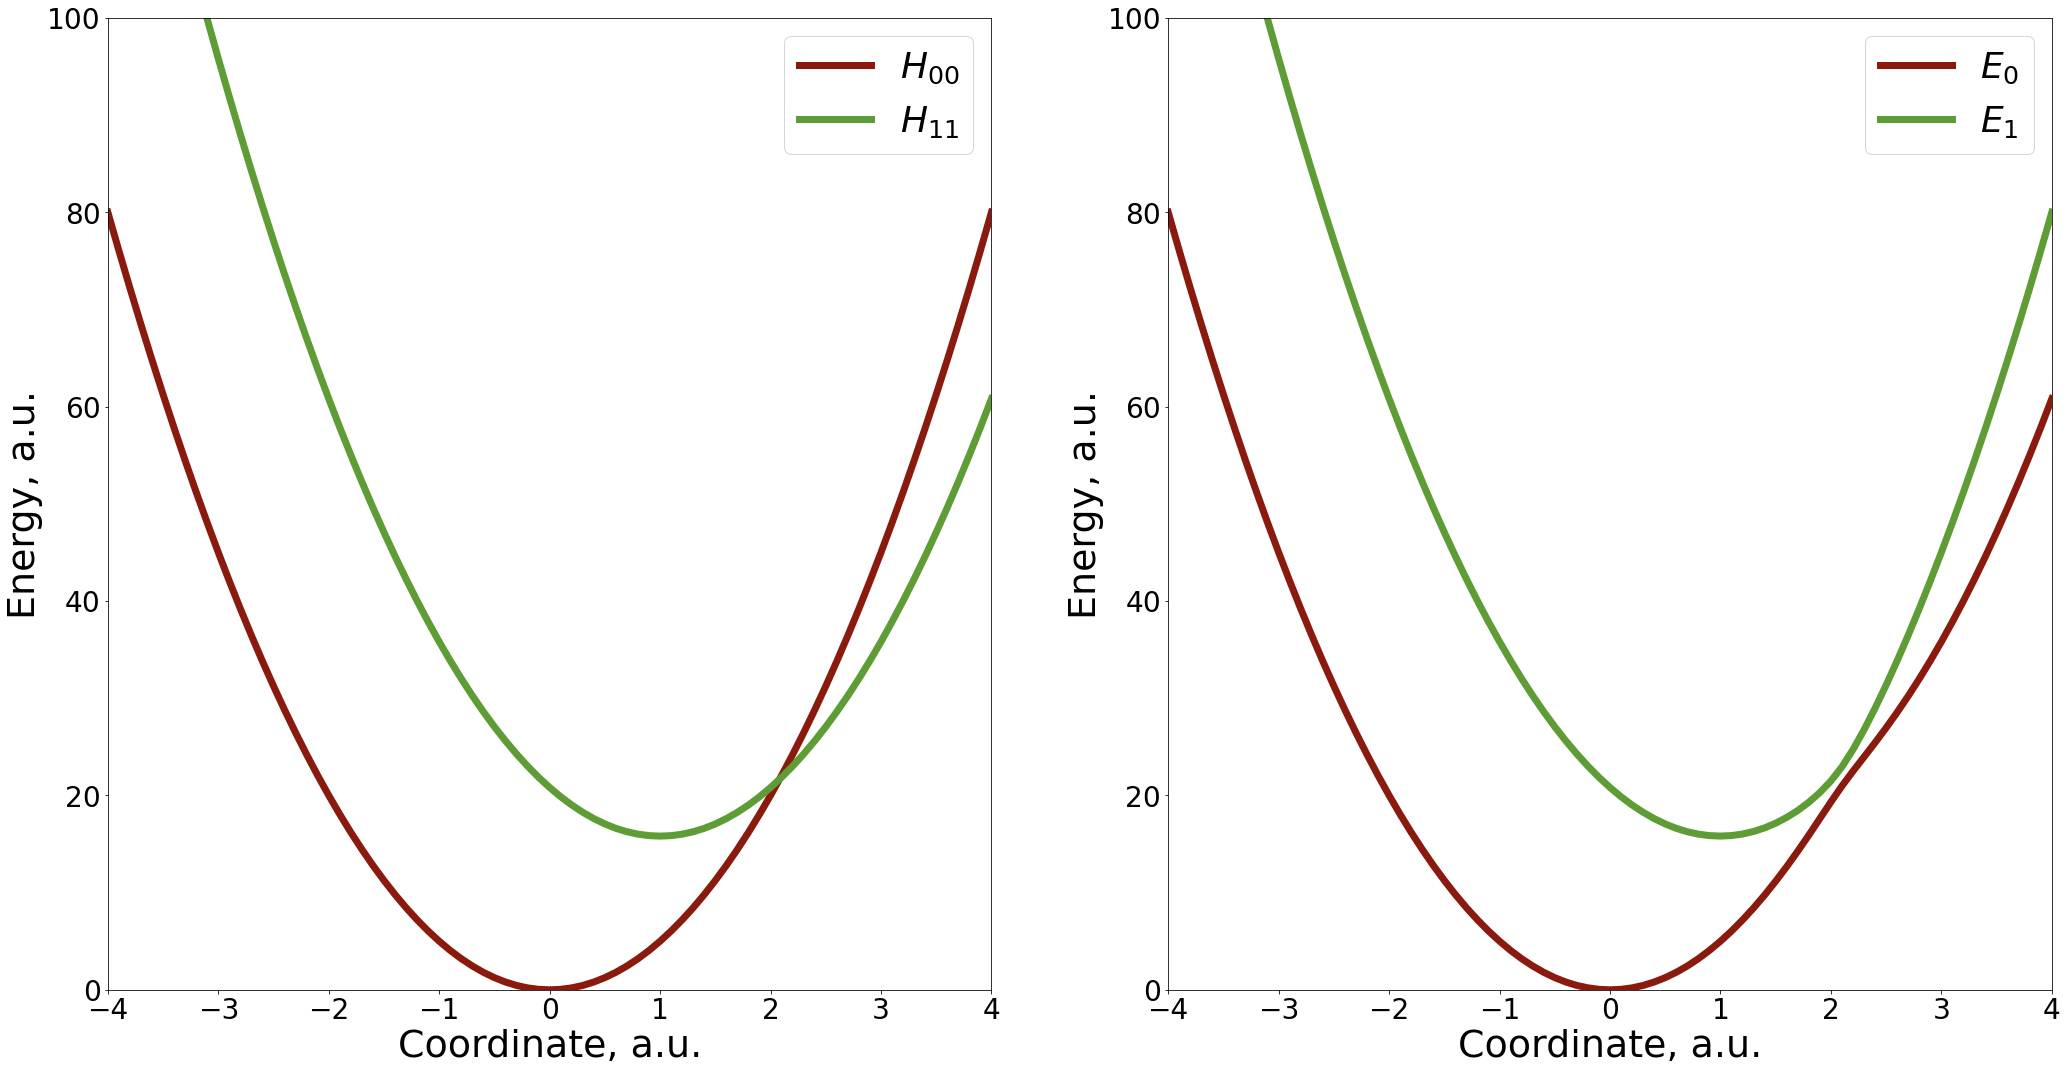

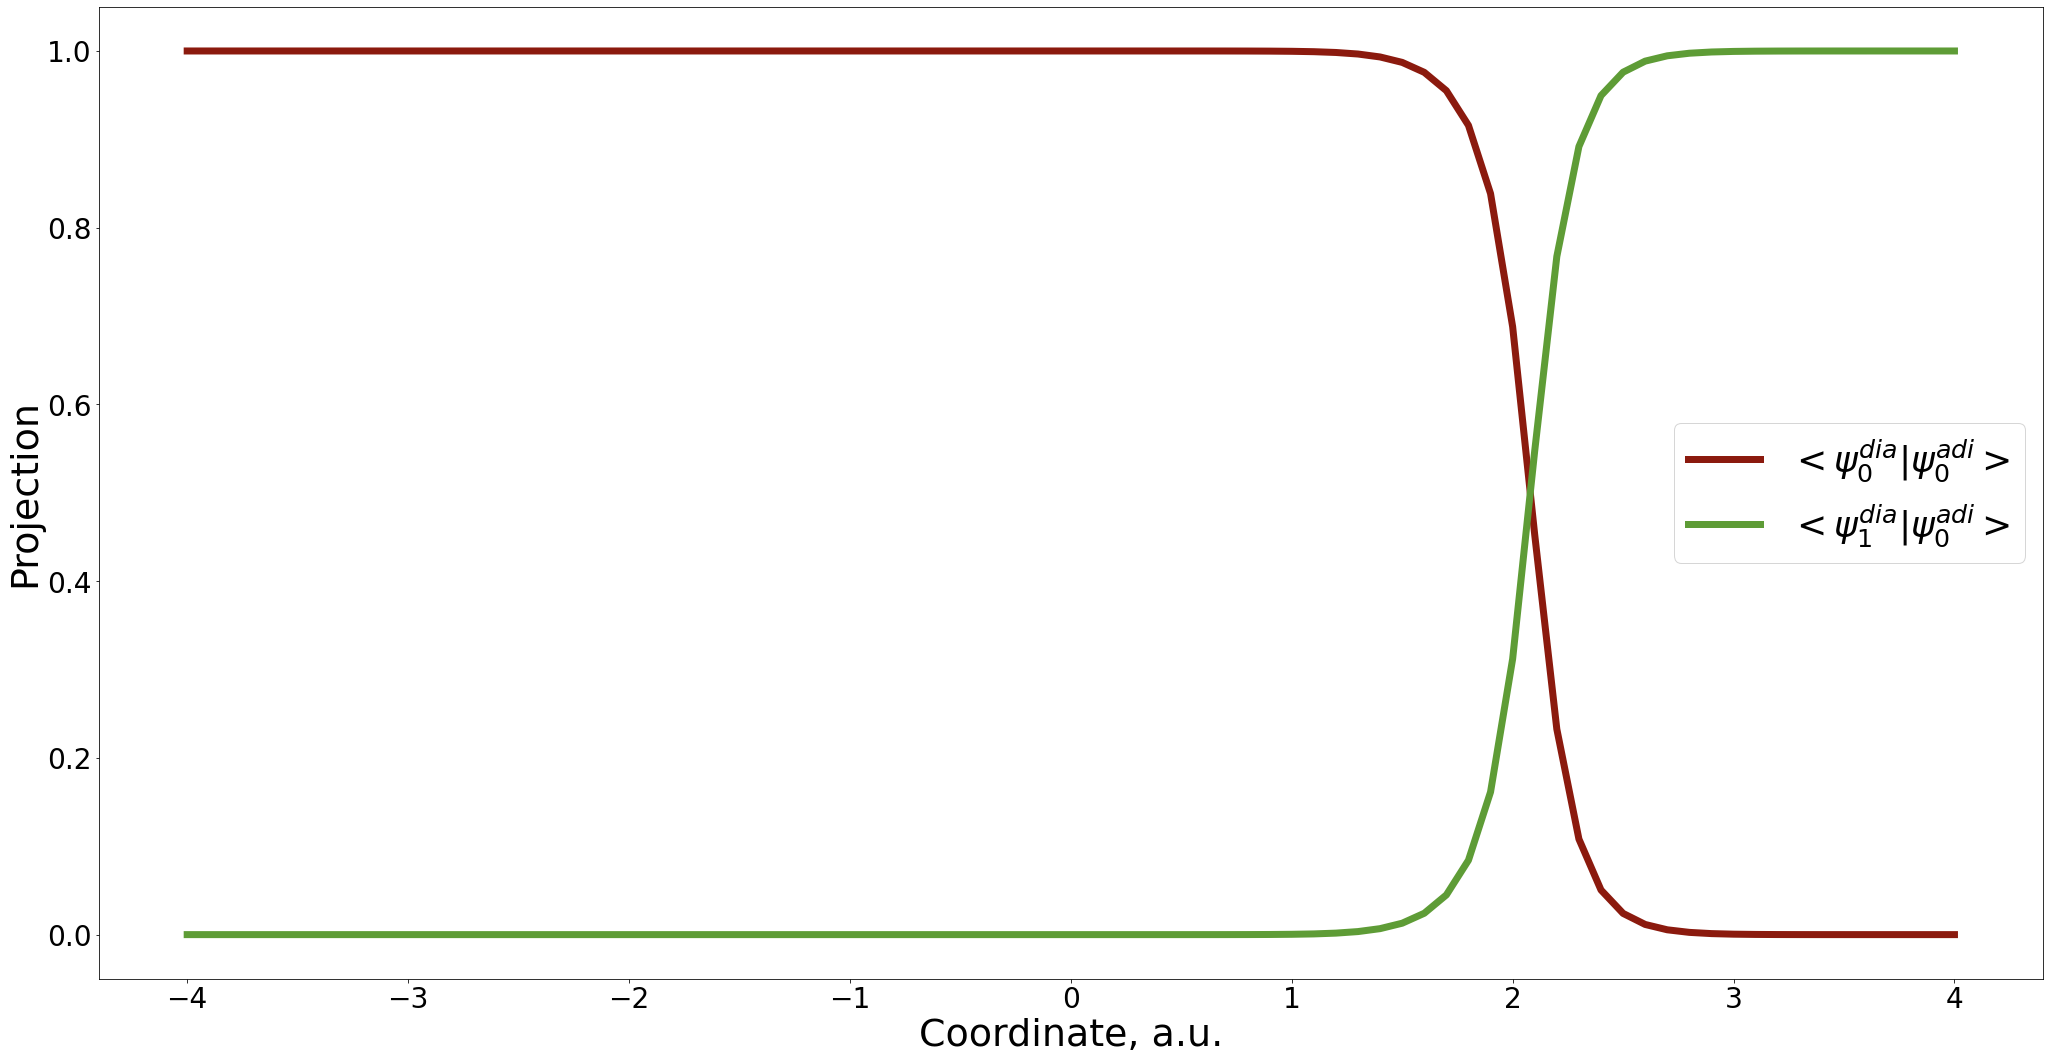

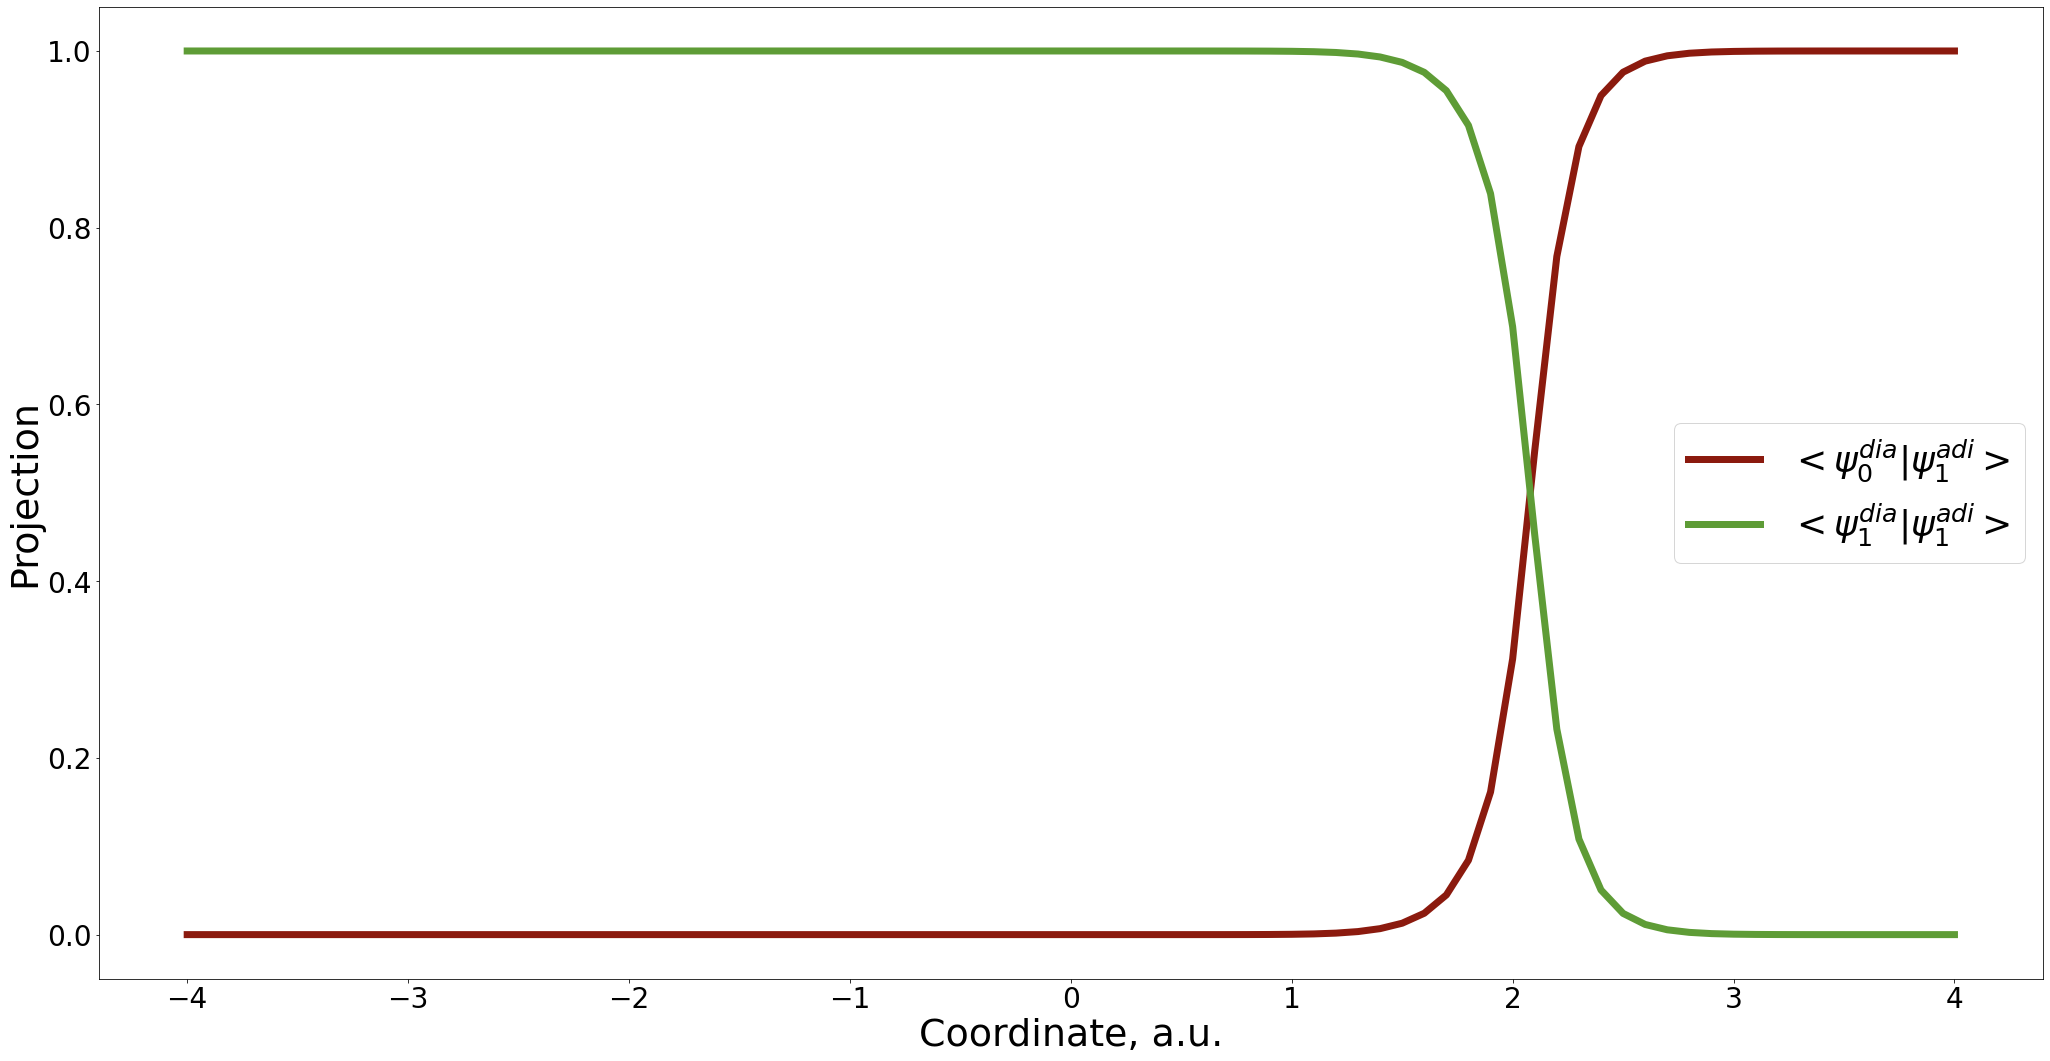

In [7]:
model_params['nstates'] = 2
plot_params = {"xlim":[-4,4], "ylim":[0,100]}
dynamics_plotting.plot_surfaces(compute_model, [model_params], [0,1], -4.0, 4.0, 0.1, plot_params)

## 2. Running QTAG Dynamics

[Back to TOC](#Table-of-Contents) <a name="Running-QTAG-Dynamics"></a>

Next, we define the user interface for the QTAG method via the ``run_qtag`` function. This function, given a list of user-defined parameters for both the dynamics (``dyn_params``) and for the potential model (``model_params``), handles all of the interfacing with the qtag modules imported in the first cell. Specific details for this function can be seen below as in-line comments.

In [8]:
#Parameters for general simulation
dyn_params = {
    "init_placement":0,
    "wfc_q0":[-2.0], "wfc_p0":[0.0], "wfc_a0":[1.0], "wfc_s0":[0.0],
    "states":[0, 1],
    "grid_dims":[25], "alp_scl":[6.0], "rho_cut":1e-12,    
}


ntraj, Q, P, A, S, active_states = initialize.initialize(dyn_params)

In [9]:
print(ntraj, active_states)

50 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [10]:
Q0 = MATRIX(1,1); Q0.set(0,0, -2.0)
P0 = MATRIX(1,1); P0.set(0,0, 0.0)
A0 = MATRIX(1,1); A0.set(0,0, 1.0)
S0 = MATRIX(1,1); S0.set(0,0, 0.0)
istate = [0]

C = initialize.coeffs(Q0, P0, A0, S0, istate, Q, P, A, S, active_states)

In [11]:
data_outs.print_matrix(C)

(3.022623418647962e-10+0j)  
(7.697816072614085e-09+0j)  
(1.5837817405651728e-07+0j)  
(2.4393330479985983e-06+0j)  
(2.8167586838768934e-05+0j)  
(0.00024392366003086292+0j)  
(0.0015839923570392725+0j)  
(0.007713531749931392+0j)  
(0.02816781868002284+0j)  
(0.0771353112004264+0j)  
(0.15839928876335166+0j)  
(0.24392326944228349+0j)  
(0.281678194649702+0j)  
(0.24392326938762013+0j)  
(0.15839928874124354+0j)  
(0.07713531127364531+0j)  
(0.028167818662253364+0j)  
(0.007713531740305955+0j)  
(0.0015839923609536066+0j)  
(0.0002439236598844631+0j)  
(2.8167584515102068e-05+0j)  
(2.4393416248394417e-06+0j)  
(1.583649519229513e-07+0j)  
(7.720954323803264e-09+0j)  
(2.8826464674482077e-10+0j)  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  


Once the parameters are set, we're ready to run QTAG! The output directory is specified using the `data_dir` variable, and the code is executed with the `run_qtag` function.

In [12]:
# 1D mass
iM = MATRIX(1, 1);  iM.set(0,0,5.58e-4);

#2D mass
#mass = MATRIX(2,1); mass.set(0,0,1793.0); mass.set(1,0,19485.0)
#iM = MATRIX(2,1); iM.set(0,0,5.58e-4); iM.set(1,0,5.13e-5)

#Parameters for general simulation
dyn_params = {
    "target_states":[0,1], "states":[0,1],
    "dt":0.01, "nsteps":800, "iM":iM,
    "hdf5_output_level":0, "txt2_output_level":3, 
    "properties_to_save":["time","Etot","pops","q","p","a","coeffs"],
    "q_update_method":1, "p_update_method":1, "a_update_method":1, "s_update_method":0,  
    "q_sync_method":1, "p_sync_method":0, "a_sync_method":0, "s_sync_method":0,
    "mom_calc_type":1, "linfit_beta":1e-3, "decpl_den":0.1,
    "qtag_pot_approx_method":2,
    "prefix":"out"
}


compute.run_qtag(Q, P, A, S, active_states, C, iM, dyn_params, compute_model, model_params)

21.25027899900891 [0.9999999999576367, 4.77163367287428e-14]
21.25027900238312 [1.0000000001030238, 4.274759825776128e-13]
21.250279001859337 [1.0000000000599003, 1.1765515941986423e-12]
21.250279003302634 [1.0000000001035187, 2.2743823704601933e-12]
21.25027900195182 [1.0000000001075933, 3.690932131517534e-12]
21.250279001264786 [1.0000000000876845, 5.387623902527564e-12]
21.25027900043216 [1.0000000000534197, 7.318535040252592e-12]
21.25027900104305 [1.0000000001004177, 9.431811642301563e-12]
21.25027900130155 [1.0000000001126532, 1.1671253544383437e-11]
21.25027900143906 [1.0000000000754912, 1.3978016278267849e-11]
21.250279002119058 [1.0000000001114324, 1.6292372111664877e-11]
21.250279002914322 [1.000000000097137, 1.8555471929420425e-11]
21.250279002073828 [1.000000000048156, 2.07110493677225e-11]
21.250279003960056 [1.0000000001441602, 2.2707012917821835e-11]
21.250279002106794 [1.0000000000454599, 2.449687548208349e-11]
21.250279001802422 [1.0000000000539422, 2.6040977971362232e

21.25021300901597 [0.9999937515805646, 2.0416522650541202e-11]
21.250201535891488 [0.9999928093568821, 2.111665663755594e-11]
21.250188312098427 [0.9999917424655507, 2.2082236661792442e-11]
21.25017310920808 [0.9999905369390033, 2.3357193002472558e-11]
21.250155673952353 [0.9999891774198354, 2.4978890523978476e-11]
21.250135726497952 [0.9999876471567721, 2.69754256411766e-11]
21.250112958304502 [0.9999859279001871, 2.9363192894871306e-11]
21.250087062038304 [0.999983996693238, 3.2154598724683795e-11]
21.250057594160072 [0.9999818375219216, 3.532704785392127e-11]
21.250024182256933 [0.9999794241485159, 3.88526365725861e-11]
21.24998637974537 [0.999976731452861, 4.268740526684975e-11]
21.24994373926014 [0.9999737273818508, 4.6788032354445964e-11]
21.24989567735823 [0.9999703853674329, 5.108498236801693e-11]
21.24984156119593 [0.9999666779440428, 5.548147103710072e-11]
21.24978090749922 [0.9999625542821571, 5.993267322549303e-11]
21.249712859271003 [0.9999579923130585, 6.433031993947944e-

11.292044330686297 [0.6335583281785663, 1.857067409104557e-09]
11.285917503318116 [0.6332349369782876, 2.0006424997759083e-09]
11.279730605508291 [0.6329082069266971, 2.2143216730384367e-09]
11.273474927632396 [0.6325773954056483, 2.45811290712757e-09]
11.2671426987868 [0.6322422896808273, 2.692834291926836e-09]
11.260729845512719 [0.631902652956586, 2.8866806917146017e-09]
11.25423135237295 [0.631557906067656, 3.0193630341787434e-09]
11.247641814225672 [0.6312078014069602, 3.084576147819435e-09]
11.240959124842995 [0.630851907720259, 3.0891730496955257e-09]
11.234180115743358 [0.6304901355061245, 3.0506098842443133e-09]
11.227305700076549 [0.6301217243438838, 2.9918988020677605e-09]
11.220330460938294 [0.6297469613129427, 2.936451287604848e-09]
11.213259800327398 [0.6293651412797124, 2.9028289380664465e-09]
11.20609141019518 [0.6289756451519014, 2.9012958948343586e-09]
11.198823670268126 [0.6285783767343436, 2.9320164413161273e-09]
11.191459971783123 [0.6281727835142588, 2.98616135853

9.672978432829234 [0.5380760760815387, 3.0190878112363316e-09]
9.672491700835076 [0.5380497521439143, 3.0190877841586722e-09]
9.671989196690715 [0.538021461836115, 3.0190877546479145e-09]
9.67148902680802 [0.5379908911062992, 3.0190877190304392e-09]
9.6710050396494 [0.5379576556381843, 3.019087676026422e-09]
9.670609952775948 [0.5379210705366312, 3.0190876264726055e-09]
9.670408480426902 [0.5378799221556214, 3.019087571489301e-09]
9.670620885113125 [0.5378313129056631, 3.019087512436632e-09]
9.67165438446798 [0.5377662832261582, 3.0190874494575012e-09]
9.673959830698166 [0.5376543748167608, 3.0190873791155955e-09]
9.677159281107791 [0.5374047557664929, 3.0190872939942144e-09]
9.674722380859551 [0.5366839125949039, 3.0190871870318343e-09]
9.593930285342662 [0.5346140215338392, 3.0190870541368697e-09]
9.562516325635428 [0.5307193689854226, 3.01908689375069e-09]
9.50916467003069 [0.521239855197124, 3.0190867055642487e-09]
9.291619958260512 [0.5095908612790786, 3.0190864865779266e-09]
9.21

8.474924609457272 [0.4861475366604004, 3.019009866112964e-09]
8.474688797425774 [0.48613035760990997, 3.0190096790434075e-09]
8.474402040356061 [0.48611258714389993, 3.0190094797594427e-09]
8.47406309035296 [0.48609426516822646, 3.0190092686957642e-09]
8.473677426993323 [0.4860753173079876, 3.019009048884135e-09]
8.473258457832914 [0.48605571390912483, 3.019008820860937e-09]
8.47282935015441 [0.4860354827648815, 3.0190085812236576e-09]
8.472410234029045 [0.48601478618294097, 3.019008325898567e-09]
8.472031513857962 [0.48599382517545864, 3.019008054565243e-09]
8.471727103369599 [0.4859728682940541, 3.0190077647560286e-09]
8.471514853263336 [0.4859521674657111, 3.0190074465019933e-09]
8.47140146693111 [0.485931944666186, 3.019007099774017e-09]
8.471409731561458 [0.4859124486070811, 3.0190067382284433e-09]
8.471539658211048 [0.4858938071077965, 3.019006361992283e-09]
8.471789226282286 [0.48587608186852926, 3.0190059589533656e-09]
8.472130898522272 [0.4858592401966845, 3.0190055284242036e-

8.424499795550398 [0.48478442228288926, 3.0189840818177243e-09]
8.424614650015782 [0.4847784317619657, 3.018984065933267e-09]
8.424728278502666 [0.48477118369518046, 3.0189840491226644e-09]
8.424835060546608 [0.4847628074756249, 3.018984030848166e-09]
8.424931573084622 [0.48475364820034683, 3.01898400997905e-09]
8.425012605611125 [0.48474419976368505, 3.0189839862067197e-09]
8.425073761861343 [0.4847350012490983, 3.018983960907816e-09]
8.425113200316737 [0.4847265198974732, 3.0189839341788736e-09]
8.425128929725282 [0.4847190528061614, 3.0189839041615327e-09]
8.425124045859015 [0.4847127259336319, 3.018983870308139e-09]
8.425100942977549 [0.48470749795757145, 3.0189838336733074e-09]
8.425066296677374 [0.48470323379543306, 3.0189837929673773e-09]
8.425031250004434 [0.4846997605758284, 3.0189837443644005e-09]
8.425009948454845 [0.4846969131028204, 3.0189836840079495e-09]
8.425015669746935 [0.4846945401729782, 3.0189836096698036e-09]
8.425056446954551 [0.4846924864762147, 3.01898352483518

8.415123202954518 [0.48433019931899923, 3.0189556315650686e-09]
8.414935079227496 [0.4843250967948403, 3.018955488263092e-09]
8.414742067920033 [0.48431979835322375, 3.0189553567895996e-09]
8.414545269346585 [0.4843143329167407, 3.018955230549524e-09]
8.41434352045794 [0.4843086619982485, 3.0189551110723297e-09]
8.414137966821057 [0.48430281673749614, 3.018954994248183e-09]
8.413927424186044 [0.48429675624241625, 3.0189548738486524e-09]
8.413713086139719 [0.48429051404539536, 3.018954748352284e-09]
Total wall time:  60.672738790512085


(<liblibra_core.MATRIX at 0x2b402c415c00>,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 <liblibra_core.CMATRIX at 0x2b402ab66db0>)

In [13]:
help(compute.run_qtag)

Help on function run_qtag in module libra_py.dynamics.qtag.compute:

run_qtag(_q, _p, _alp, _s, _states, _coeff, _iM, _dyn_params, _compute_model, _model_params)
    Args: 
        _q ( MATRIX(nnucl, ntraj) ): coordinates of the "classical" particles [units: Bohr]
        _p ( MATRIX(nnucl, ntraj) ): momenta of the "classical" particles [units: a.u. of momenta]
        _alp ( MATRIX(nnucl, ntraj) ): widths of the GBFs [ units: Bohr^-1 ]
        _s ( MATRIX(1, ntraj) ): phases of all GBFs [ units: no ]
        _states ( intList, or list of ntraj ints ): the quantum state of each trajectory
        _coeff ( CMATRIX(nstates, ntraj) ): amplitudes of the GBFs
        _iM ( MATRIX(nnucl, 1) ): masses of classical particles [units: a.u.^-1]
        _dyn_params ( dictionary ): parameters controlling the execution of the dynamics
            Can contain:
    
            * **q_update_method** (int): the parameter specifying whether positions should be updated (adaptable) or frozen  
    
      

## 3. Data Visualization

[Back to TOC](#Table-of-Contents) <a name="Data-Visualization"></a>

With the simulation finished, we can start plotting some of the output data we requested via the `properties_to_save` parameter in the `dyn_params` dictionary.

Note that a new dictionary is needed for plotting: `plt_params`. This dictionary is uniquely specified for each set of plots we want to make (for this tutorial, all necessary parameters for the `qtag_plots` functionality are given each time). Here, we're plotting the wavefunction density at various snapshots in the simulation using the `qtag_plots.wf_plot` function, which relies on gridded wavefunction data reconstructed from our output via the `qtag_calc.wf_calc_nD` function.

Number of files = 5


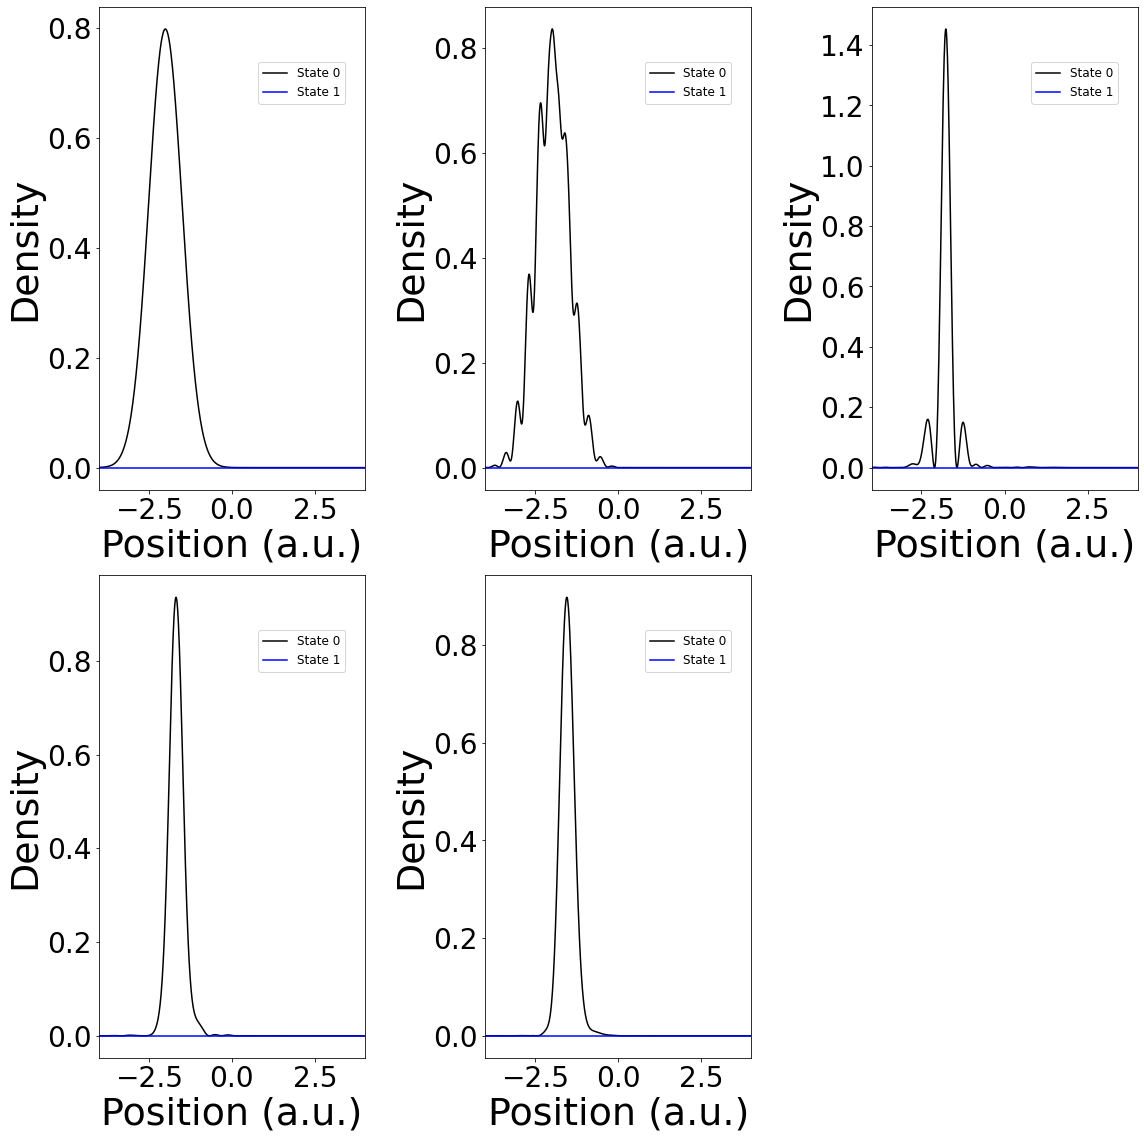

In [14]:
#Plot parameters dictionary definitions for wavefunction output...
plt_params = {'prefix':"out", 'which_states':[0,1], 
              'size':(16,16), 'xmin':[-4.0],'xmax':[4.0],
              'npoints':[800], 'snaps':[0,199,399,599,799],
              'xlabel':'Position (a.u.)', 'ylabel':'Density', 'zlabel':'N/A',
              '1Dcolors':['Black','Blue'], '2Dcolors':['Reds','Blues'],
              'legend_loc':(0.6,0.8), 'legend_size':12,
              "grid_dims":[25]
             }

dyn_params.update( { "grid_dims":[25], "ndof":1 } )

#Call wf_calc_nD to calculate gridded wavefunction data from coefficients and qpas output...
qtag_calc.wf_calc_nD(dyn_params, plt_params, "out")

#Plot the selected snapshots...
plot.wf_plot(dyn_params, plt_params)

Now, we plot the surface populations and energy conservation using the `qtag_plots.energy_and_pops` function:

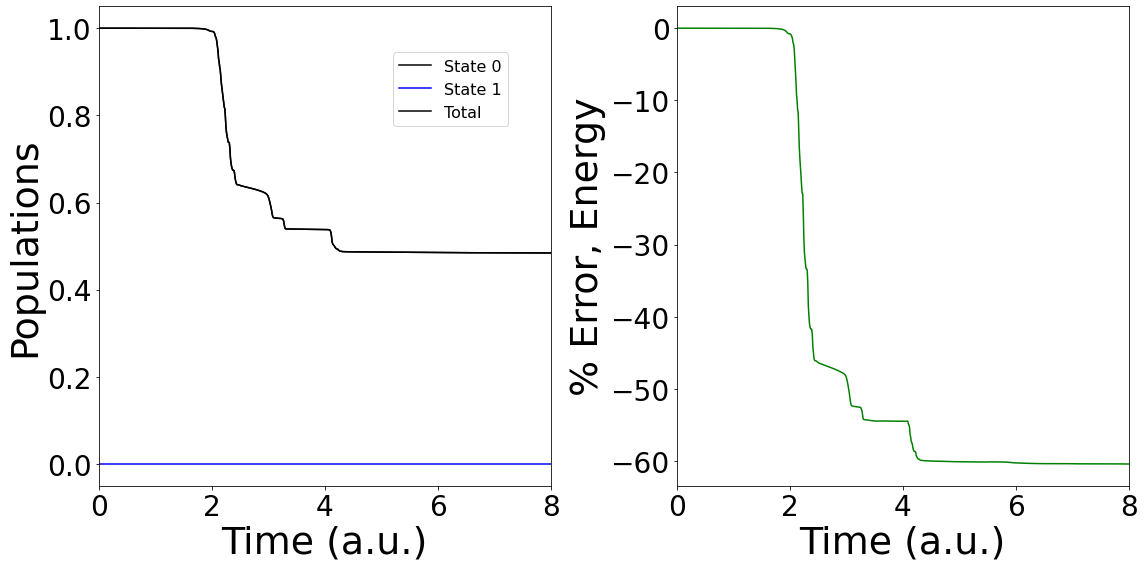

In [15]:
#Plot parameters dictionary definitions for energy/population output...
plt_params = {'prefix':"out", 'size':(16,8), 'xmin':[0], 'xmax':[8.0], 
              '1Dcolors':['Black','Blue'], 'legend_loc':(0.65,0.75), 'legend_size':16}

#Plot the graphs...
plot.energy_and_pops(dyn_params, plt_params)

Finally, lets look at the trajectories themselves with the `qtag_plots.trajectories` function:

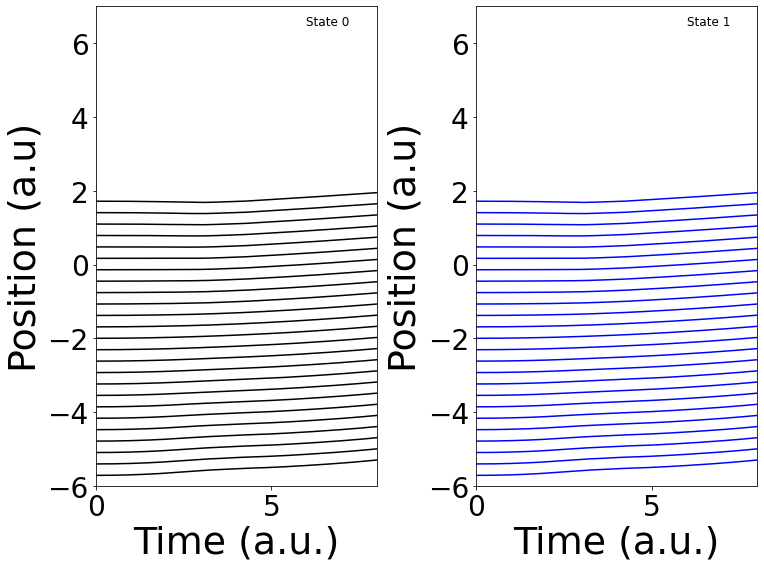

In [16]:
#Plot parameters dictionary definitions for trajectory output...
plt_params = {'prefix':"out", 'which_states':[0, 1], 'which_traj':'all', 
              'size':(16,8), 'xmin':[0,-6.0],'xmax':[8.0,7.0],
              'xlabel':'Time (a.u.)', 'ylabel':'Position (a.u)', 'zlabel':'N/A',
              '1Dcolors':['Black','Blue']}

#Plot the output...
plot.trajectories(dyn_params, plt_params)

The plotting utility used here is `matplotlib.pyplot` -- any user-defined plotting functions constructed in the notebook can be utilized to visualize the data! The output files are stored in the directory specified by `data_dir`; Libra has a useful function for importing it to Python array-like formats called `data_read.get_data_from_file2(filename, which_cols)`, which takes as arguments the relative path to the file and the numbers of the columns to be read, respectively. Just remember to import it in your Jupyter Notebook first (`from libra_py import data_read`)!

An example of a custom plotting function for basis momenta is defined below:

In [17]:
from libra_py import data_read

def my_plotting_fxn(dyn_params, plt_params):
    
    #Define local variables according to dictionary inputs...
    prefix = plt_params['prefix']
    colors = plt_params['1Dcolors']
    states = sorted(dyn_params['states'])
    nstates = len(states)
    ndof = dyn_params['ndof']
    
    #Set up the plotting regions...
    fig = plt.figure(figsize = plt_params['size'])
    colors = plt_params['1Dcolors']
    xlimits = [plt_params['xmin'][0],plt_params['xmax'][0]]

    #Do some basic error handling with which states are specified...
    which_states = plt_params['which_states']
    if type(which_states) == str:
        which_states == which_states.lower()
    elif type(which_states) == list:
        which_states = sorted(which_states)
    else:
        sys.exit('Error in which_states parameter in plt_params dict! Type should be list or "all"')
    if which_states == 'all':
        which_states = [state for state in range(nstates)]

    #Establish the number of trajectories...
    ntraj = 1
    for n in range(ndof):
        ntraj *= dyn_params["grid_dims"][n]
        
    #Read the data from the appropriate files...
    
    tfile = f"{prefix}/time.txt" #Name of file w/ time data
    afile = f"{prefix}/a.txt" #Name of file w/ momentum data
    
    tdata = data_read.get_data_from_file2(tfile,[0])
    adata = data_read.get_data_from_file2(afile, [traj for traj in range(ntraj*nstates)])
    
    #Separate the data into an array for plotting...
    nsteps = len(tdata[0])
    anew = np.zeros((nstates,ntraj,nsteps),dtype=float)

    for state in range(nstates):
        for traj in range(ntraj):
            anew[state][traj] = adata[traj+ntraj*state]

    #Do some basic error handling with which trajectories are specified...
    which_traj = plt_params['which_traj']
    if type(which_traj) == str:
        which_traj = which_traj.lower()
    elif type(which_traj) == list:
        which_traj = sorted(which_traj)
    else:
        sys.exit('Error in which_traj parameter in plt_params dict! Type should be list or "all"')
    if which_traj == 'all':
        which_traj = [traj for traj in range(ntraj)]

    labels = []
    for state in which_states:
        labels.append("State "+str(state))

    #Plot the figure and subfigures (1 subfigure per state)...
    fig = plt.figure(figsize=plt_params['size'])
    xlimits = [plt_params['xmin'][0],plt_params['xmax'][0]]
    ylimits = [plt_params['xmin'][1],plt_params['xmax'][1]]
    m = int(np.ceil(len(which_states)/3.0))
    for state in which_states:
        ax = fig.add_subplot(m,3,state+1)
        for traj in which_traj:
            x, y = tdata[0], anew[state][traj]

            ax.plot(x, y, color=colors[state])

        ax.set_xlabel(plt_params['xlabel'])
        ax.set_ylabel(plt_params['ylabel'])

        ax.axes.set_xlim(xlimits[0],xlimits[1])
        ax.axes.set_ylim(ylimits[0],ylimits[1])
        ax.text(0.5,3.5,labels[state],fontsize=12)
    plt.tight_layout()
    

<Figure size 1152x576 with 0 Axes>

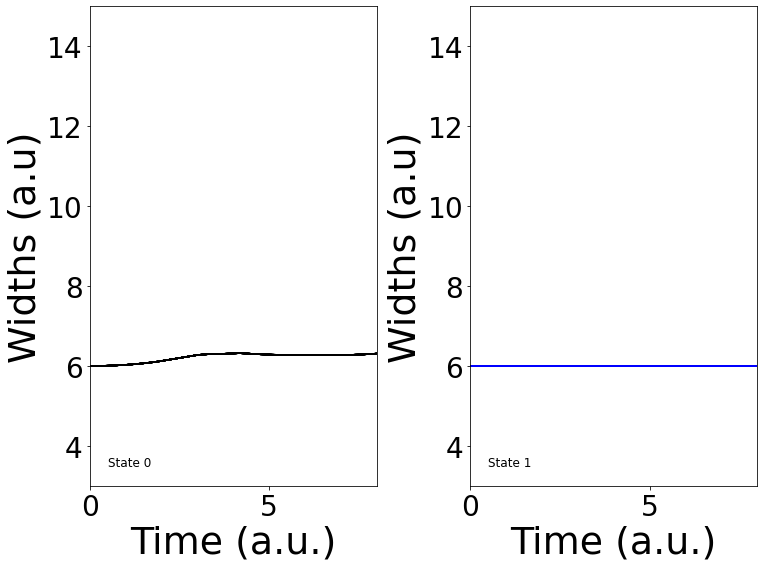

In [18]:
#Plot parameters dictionary definitions for trajectory output...
plt_params = {'prefix':"out", 'which_states':[0,1], 'which_traj':'all', 
              'size':(16,8), 'xmin':[0,3],'xmax':[8.0,15.0],
              'xlabel':'Time (a.u.)', 'ylabel':'Widths (a.u)', 'zlabel':'N/A',
              '1Dcolors':['Black','Blue']}

#Plot the output...
my_plotting_fxn(dyn_params, plt_params)